In [1]:
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.multi_objective import qExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective import pareto
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt


/opt/homebrew/Caskroom/miniconda/base/envs/botorch_mar2024/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import DTLZ2_model
import fischer_model
from botorch.test_functions.multi_objective import DTLZ2
from DTLZ2_model import neg_l1_dist
from DTLZ2_model import predict_DTLZ2_model
from fischer_model import predict_fischer_model
import torch
import numpy as np
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
dim = 4
N = 100
MC_SAMPLES = 128
NUM_RESTARTS = 10
RAW_SAMPLES = 512

BATCH_SIZE = 5
iteration_number = 10
#bounds of the inputs
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)]).to(device=device, dtype=dtype)
refi = torch.tensor([0., 0. ,0. , 0.], device=device, dtype=dtype)

In [4]:
# train_x = torch.rand(100, 4, dtype=torch.float32)
train_x = draw_sobol_samples(bounds=bounds, n=1, q=N).squeeze(0).to(device=device, dtype=dtype)
train_y = predict_fischer_model(train_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [5]:
train_x, train_y

(tensor([[0.5943, 0.7762, 0.3248, 0.5592],
         [0.6719, 0.5506, 0.3612, 0.7720],
         [0.2095, 0.9565, 0.0043, 0.9964],
         [0.5431, 0.3765, 0.7090, 0.2292],
         [0.2463, 0.4280, 0.8376, 0.4179],
         [0.9084, 0.7392, 0.6415, 0.5844],
         [0.9715, 0.3346, 0.0563, 0.9613],
         [0.1393, 0.9208, 0.2818, 0.4665],
         [0.3084, 0.6547, 0.5339, 0.9640],
         [0.6873, 0.8698, 0.9113, 0.4843],
         [0.4167, 0.1959, 0.2702, 0.1988],
         [0.8864, 0.2740, 0.7761, 0.0827],
         [0.5039, 0.7623, 0.6755, 0.6975],
         [0.4878, 0.3114, 0.9935, 0.7372],
         [0.8753, 0.7372, 0.0501, 0.2223],
         [0.8617, 0.0550, 0.9410, 0.7298],
         [0.9168, 0.9272, 0.6063, 0.3180],
         [0.7074, 0.9468, 0.2932, 0.6373],
         [0.6809, 0.8718, 0.6779, 0.4578],
         [0.0856, 0.0307, 0.6290, 0.2463],
         [0.9564, 0.4181, 0.8212, 0.1261],
         [0.9676, 0.3237, 0.6846, 0.0870],
         [0.9269, 0.5986, 0.1461, 0.3493],
         [0

In [7]:
# # Initialize models for each objective
# models = [SingleTaskGP(train_X=train_x, train_Y=train_y[:, i].unsqueeze(-1)) for i in range(train_y.shape[-1])]

# # Fit models
# mlls = [ExactMarginalLogLikelihood(model.likelihood, model) for model in models]
# for mll in mlls:
#     fit_gpytorch_model(mll)

# # Combine models into a ModelListGP
# model = ModelListGP(*models)

In [9]:
model = SingleTaskGP(train_X=train_x, train_Y=train_y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [10]:
#condition for the pareto front
partitioning = FastNondominatedPartitioning(
    ref_point=refi,
    Y=train_y,
    )

In [11]:
for i in range(iteration_number):
    print("Iteration: "+str(i))
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=refi,
        partitioning=partitioning,
        #sampler=qehvi_sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = candidates.detach()
    new_y = predict_fischer_model(new_x)

    train_x=torch.vstack([train_x,new_x])
    train_y=torch.vstack([train_y,new_y])

    models = [SingleTaskGP(train_X=train_x, train_Y=train_y[:, i].unsqueeze(-1)) for i in range(train_y.shape[-1])]

 # Fit models
    mlls = [ExactMarginalLogLikelihood(model.likelihood, model) for model in models]
    for mll in mlls:
        fit_gpytorch_model(mll)
    model = ModelListGP(*models)

    partitioning = FastNondominatedPartitioning(
        ref_point=refi,
        Y=train_y,
        )

Iteration: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Iteration: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Iteration: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Iteration: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Iteration: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Iteration: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Iteration: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


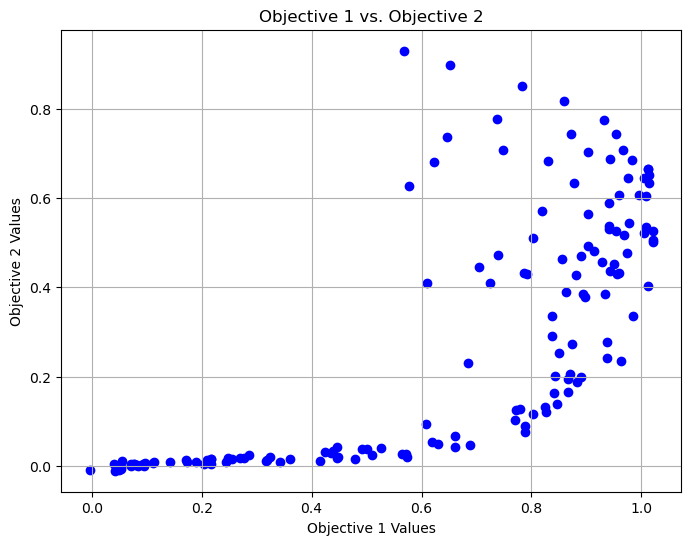

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y[:, 0].cpu().numpy(), train_y[:, 1].cpu().numpy(), color='blue')
plt.title('Objective 1 vs. Objective 2')
plt.xlabel('Objective 1 Values')
plt.ylabel('Objective 2 Values')
plt.grid(True)
plt.show()

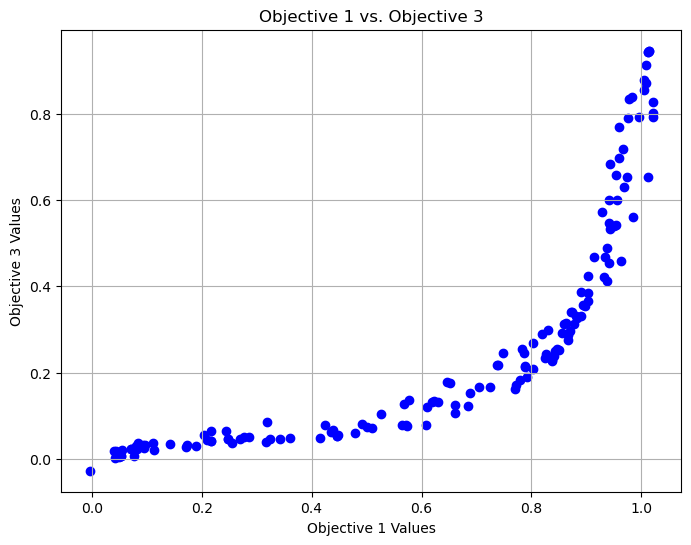

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y[:, 0].cpu().numpy(), train_y[:, 2].cpu().numpy(), color='blue')
plt.title('Objective 1 vs. Objective 3')
plt.xlabel('Objective 1 Values')
plt.ylabel('Objective 3 Values')
plt.grid(True)
plt.show()

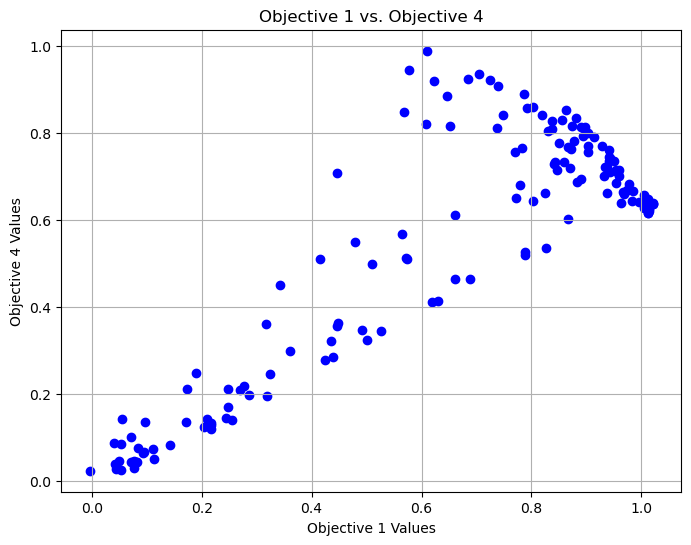

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y[:, 0].cpu().numpy(), train_y[:, 3].cpu().numpy(), color='blue')
plt.title('Objective 1 vs. Objective 4')
plt.xlabel('Objective 1 Values')
plt.ylabel('Objective 4 Values')
plt.grid(True)
plt.show()

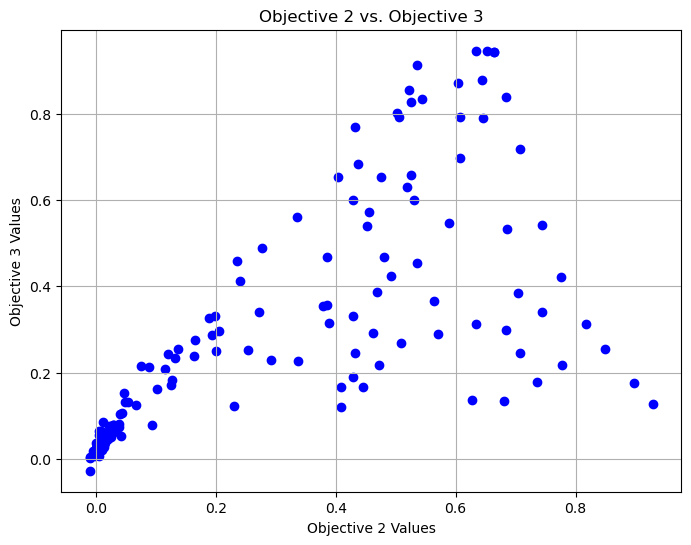

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y[:, 1].cpu().numpy(), train_y[:, 2].cpu().numpy(), color='blue')
plt.title('Objective 2 vs. Objective 3')
plt.xlabel('Objective 2 Values')
plt.ylabel('Objective 3 Values')
plt.grid(True)
plt.show()

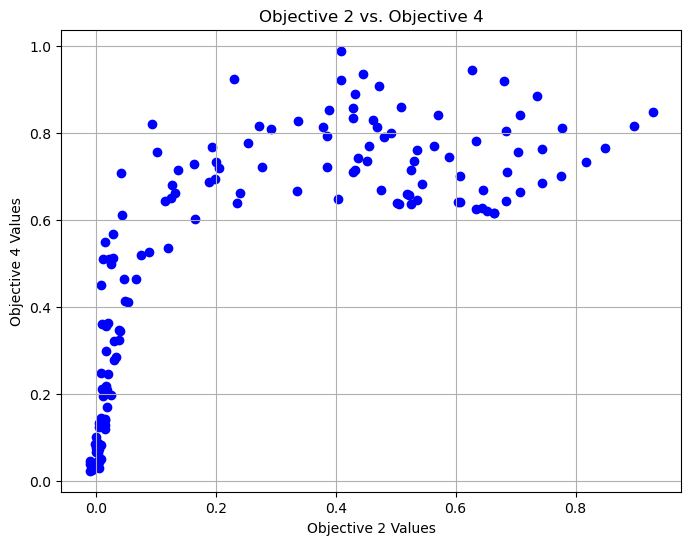

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y[:, 1].cpu().numpy(), train_y[:, 3].cpu().numpy(), color='blue')
plt.title('Objective 2 vs. Objective 4')
plt.xlabel('Objective 2 Values')
plt.ylabel('Objective 4 Values')
plt.grid(True)
plt.show()

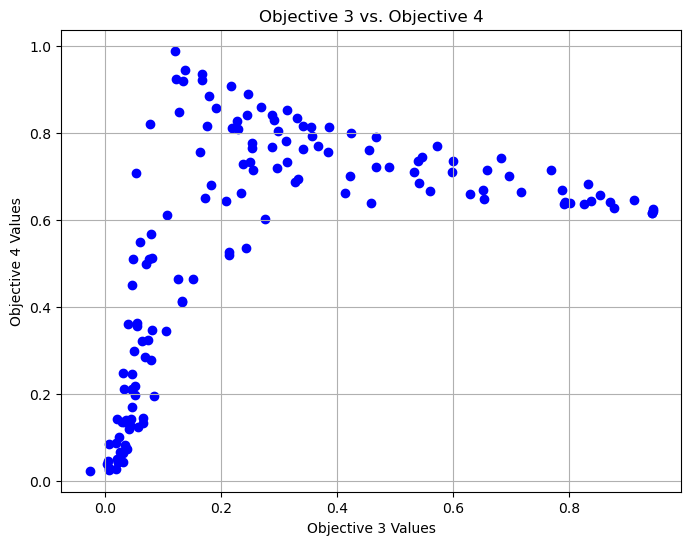

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(train_y[:, 2].cpu().numpy(), train_y[:, 3].cpu().numpy(), color='blue')
plt.title('Objective 3 vs. Objective 4')
plt.xlabel('Objective 3 Values')
plt.ylabel('Objective 4 Values')
plt.grid(True)
plt.show()